## Imports

In the next version of Tensor Flow (actual 2.19.0, next 2.20.0) some tf.lite functions will be deprecated, so in this notebook there will be also the new versions of classes and functions.

In [1]:
# The new module for edge-devices
!python3 -m pip install ai-edge-litert

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 MB 9.1 MB/s eta 0:00:00


In [2]:
# All depencies
import os
import numpy as np
import h5py # A pythonic interface to the HDF5 binary data format (for model in keras)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import accuracy_score
from ai_edge_litert.interpreter import Interpreter # The new interpreter
from sys import getsizeof

In [3]:
print(tf.__version__)

2.19.0


## Helper Functions

In [4]:
def get_file_size(file_path):
  """
  Helper function to return file size in bytes
  """
  size = os.path.getsize(file_path)
  return size

In [5]:
def convert_bytes(size, unit=None):
  """
  Helper function to return file size in different units
  """
  if unit == "KB":
    return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
  elif unit == "MB":
    return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
  else:
    return print('File size: ' + str(size) + ' bytes')

## Import the Fashion MNIST Dataset

[Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>


In [6]:
# Load the fashion mnist dataset, dividing it into train and test sets
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress',
               'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Explore Training data


In [8]:
# The images are numpy 3d (number of images, x_dim, y_dim) dimensional arrays
print(type(train_images))
print(train_images.shape)

<class 'numpy.ndarray'>
(60000, 28, 28)


In [9]:
len(train_labels)

60000

In [10]:
# Checking if there are ten unique classes in the array labels
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

## Explore Test Dataset

In [11]:
print(type(test_images))
print(test_images.shape)

<class 'numpy.ndarray'>
(10000, 28, 28)


In [12]:
len(test_labels)

10000

## Proprocessing

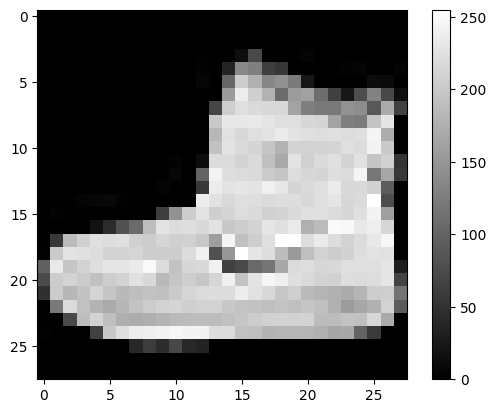

In [13]:
plt.figure()
plt.imshow(train_images[0], cmap="gray")
plt.colorbar()
plt.grid(False)
plt.show()

In [14]:
# Preprocessing to scale the values of images from [0,255] to [0,1]
# To stabilize the learning process (a good practice)
train_images = train_images / 255.0
test_images = test_images / 255.0

## Build & Compile the model

In [15]:
# A simple NN to classify the images
model = keras.Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(10) # Last layer of ten classes
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Compile the model with adam optimizator
model.compile(optimizer='adam',
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
              )

In [18]:
# The fit/train function starts the training of the models
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.7770 - loss: 0.6357
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8604 - loss: 0.3879
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8767 - loss: 0.3387
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8819 - loss: 0.3156
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8884 - loss: 0.3019
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8935 - loss: 0.2833
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9008 - loss: 0.2652
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9027 - loss: 0.2612
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9086 - loss: 0.2476
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9124 - loss: 0.2358


In [19]:
# Model reference and name
KERAS_MODEL_NAME = 'tf_model_fashion_mnist.h5'

In [20]:
# Saving the model, this will create a h5 file
model.save(KERAS_MODEL_NAME)

In [21]:
convert_bytes(get_file_size(KERAS_MODEL_NAME), "MB")

File size: 1.187 Megabytes


In [22]:
keras_model_size = get_file_size(KERAS_MODEL_NAME)

In [23]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy is {}%'.format(round(100 * test_acc, 2)))

313/313 - 1s - 2ms/step - accuracy: 0.8800 - loss: 0.3471

Test accuracy is 88.0%


## TF Lite Model

In [24]:
# Model name and reference but for the tflite model version
TF_LITE_MODEL_FILE_NAME = 'tf_lite_model.tflite'

In [25]:
# Creating a Converter from module tf.lite
# then converting the model
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

Saved artifact at '/tmp/tmpgu_i3xlg'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  136560548846800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136560548847760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136560548847184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136560548847568: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [26]:
# Saving the model in a tflite file, showing the byte size
open(TF_LITE_MODEL_FILE_NAME, 'wb').write(tflite_model)

408812

In [28]:
# As it is possible to see from this code, the file is smaller than the h5 file
convert_bytes(get_file_size(TF_LITE_MODEL_FILE_NAME), "KB")

File size: 399.23 Kilobytes


In [30]:
tf_lite_file_size = get_file_size(TF_LITE_MODEL_FILE_NAME)

## Check Input Tensor Shape

In [31]:
# Lets check how the shapes are changed
# It's necessary to create a tflite Interpreter to read correctly a tflite file
# interpreter = tf.lite.Interpreter(model_path=TF_LITE_MODEL_FILE_NAME)
new_interpreter = Interpreter(model_path=TF_LITE_MODEL_FILE_NAME) #new interpreter from ai_edge module
input_details = new_interpreter.get_input_details()
output_details = new_interpreter.get_output_details()
print('Input Shape:', input_details[0]['shape'])
print('Input Type:', input_details[0]['dtype'])
print('Output Shape:', output_details[0]['shape'])
print('Output Shape:', output_details[0]['dtype'])


Input Shape: [ 1 28 28]
Input Type: <class 'numpy.float32'>
Output Shape: [ 1 10]
Output Shape: <class 'numpy.float32'>


## Resize Tensor Shape

In [32]:
# As seen before the Input Shape accepts only one input at time
# Reshape the input and output tensor for a batch inference (without the loop)
new_interpreter.resize_tensor_input(input_details[0]['index'], (10000, 28, 28))
new_interpreter.resize_tensor_input(output_details[0]['index'], (10000, 10))
new_interpreter.allocate_tensors()
input_details = new_interpreter.get_input_details()
output_details = new_interpreter.get_output_details()
print('Input Shape:', input_details[0]['shape'])
print('Input Type:', input_details[0]['dtype'])
print('Output Shape:', output_details[0]['shape'])
print('Output Shape:', output_details[0]['dtype'])



Input Shape: [10000    28    28]
Input Type: <class 'numpy.float32'>
Output Shape: [10000    10]
Output Shape: <class 'numpy.float32'>


In [33]:
# Another problem, the model now accepts float32
# Test images are float64
print(test_images.dtype)

float64


In [34]:
# Changing the test images size
test_images_numpy = np.array(test_images, dtype=np.float32)
print(test_images_numpy.dtype)

float32


In [35]:
# Now it's possible to evaluate the tflite model
new_interpreter.set_tensor(input_details[0]['index'], test_images_numpy)
new_interpreter.invoke() # With this function the interpreter creates the outputs
tflite_model_predictions = new_interpreter.get_tensor(output_details[0]['index'])
print('Predictions results shape:', tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)


Predictions results shape: (10000, 10)


In [36]:
# For each of 10000 images we have one class predicted
acc = accuracy_score(prediction_classes, test_labels)
print(f'Test accuracy TFLITE model is {round(100*acc, 2)}')

Test accuracy TFLITE model is 88.0


In [37]:
# The accuracy is pratically the same, but the model size is changed
# the tflite file is a third of the original
tf_lite_file_size/keras_model_size

0.3285044806438756

## TF Lite Model Float 16

In [38]:
TF_LITE_MODEL_FLOAT_16_FILE_NAME = "tf_lite_float_16_model.tflite"


In [39]:
# We haven't seen how a converter can be configurated
# For instance here we want to create a 16 float tflite converter
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tf_lite_converter.target_spec.supported_types = [tf.float16]
tflite_model = tf_lite_converter.convert()

Saved artifact at '/tmp/tmpmnth8gwj'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  136560548846800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136560548847760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136560548847184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136560548847568: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [40]:
open(TF_LITE_MODEL_FLOAT_16_FILE_NAME, 'wb').write(tflite_model)

205808

In [41]:
convert_bytes(get_file_size(TF_LITE_MODEL_FLOAT_16_FILE_NAME), "KB")

File size: 200.984 Kilobytes


In [42]:
tf_lite_float_16_file_size = get_file_size(TF_LITE_MODEL_FLOAT_16_FILE_NAME)

In [43]:
tf_lite_float_16_file_size / keras_model_size

0.1653788297612466

## TF Lite Size Quantized

With the following quantization we will reduce the dtype of weights from float32 to int8

In [44]:
TF_LITE_SIZE_QUANT_MODEL_FILE_NAME = 'tf_lite_quant_model.tflite'

Model Optimization: OPTIMIZE_FOR_SIZE
This setting enables weight-only quantization.

What it does: It scans the model and converts all internal weights (the constant tensors, like the weights in a Dense layer) from 32-bit floating-point numbers (float32) to 8-bit integers (int8).

Main Benefit: The primary goal is to reduce the model's final file size by approximately 4x. This is excellent for saving storage space (ROM) on a device.

Why Input/Output is still float32: This optimization creates a "hybrid" model. The inputs and outputs remain float32. During runtime, the TFLite Interpreter performs "de-quantization" on the fly—it converts the int8 weights back to float32 before executing the calculations.

Performance Impact:

✅ Storage (ROM): Drastically reduced.

❌ Speed (Latency) & Runtime RAM: No significant improvement. Since all calculations are still performed using float32 math, we don't get the speed and memory benefits of an integer-only pipeline.

(To gain speed and reduce RAM, one would need to use Full Integer Quantization, which also converts the inputs, outputs, and intermediate math to int8 but requires a calibration dataset).

In [45]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
# WARNING: There are also optimizations for latency
tf_lite_converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = tf_lite_converter.convert()


Saved artifact at '/tmp/tmpsnbrlstd'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  136560548846800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136560548847760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136560548847184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136560548847568: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [46]:
open(TF_LITE_SIZE_QUANT_MODEL_FILE_NAME, 'wb').write(tflite_model)

105672

In [47]:
convert_bytes(get_file_size(TF_LITE_SIZE_QUANT_MODEL_FILE_NAME), "KB")

File size: 103.195 Kilobytes


In [48]:
tf_lite_float_quant_file_size = get_file_size(TF_LITE_SIZE_QUANT_MODEL_FILE_NAME)


In [49]:
tf_lite_float_quant_file_size / keras_model_size

0.08491366564239705

## Check Input Quantized Tensor Shape

As anticipated the input and output dtype are still float32, this means that the model dequantizes the weights to float32 during inference time.

For this it isn't necessary to show again the accuracy because is the same as before.

In [50]:
interpreter = Interpreter(model_path=TF_LITE_SIZE_QUANT_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print('Input Shape:', input_details[0]['shape'])
print('Input Type:', input_details[0]['dtype'])
print('Output Shape:', output_details[0]['shape'])
print('Output Shape:', output_details[0]['dtype'])

Input Shape: [ 1 28 28]
Input Type: <class 'numpy.float32'>
Output Shape: [ 1 10]
Output Shape: <class 'numpy.float32'>


## Calibration Dataset

To create a calibration dataset is important to get a **representative set** of data which the model will see. It's not a problem to take a small number of data from the training set because the purpose of quantization is to map floa32 to int8 with minimum loss of information, it's nothing correlated to the model accuracy (Post Training Quantization).

In [51]:
# The TFLite Converter needs a representative generation function
# We will use the yield python keyword, this transform a function in a generator
# It's like a return for the first cycle, then the function remember the index
def representative_data_gen():
  for i in range(100):
    image = train_images[i]

    # It's necessary to add a batch dimension for compatibility issues with the model
    image = np.expand_dims(image, axis=0).astype(np.float32)

    yield [image]


## Full Integer Quantization

In [64]:
TF_LITE_FULL_INT_QUANT_MODEL_FILE_NAME = 'tf_lite_full_int_quant_model.tflite'

In [65]:
# Now we can create a quantized model
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tf_lite_converter.representative_dataset = representative_data_gen

# Forcing the model to only use integer math
tf_lite_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tf_lite_converter.inference_input_type = tf.uint8
tf_lite_converter.inference_output_type = tf.uint8

# Model FIQ Generation
tflite_model = tf_lite_converter.convert()

Saved artifact at '/tmp/tmp0dsbogby'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  136560548846800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136560548847760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136560548847184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136560548847568: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [66]:
open(TF_LITE_FULL_INT_QUANT_MODEL_FILE_NAME, 'wb').write(tflite_model)

107896

In [67]:
interpreter = Interpreter(model_path=TF_LITE_FULL_INT_QUANT_MODEL_FILE_NAME)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print('Input Shape:', input_details[0]['shape'])
print('Input Type:', input_details[0]['dtype'])
print('Output Shape:', output_details[0]['shape'])
print('Output Shape:', output_details[0]['dtype'])

Input Shape: [ 1 28 28]
Input Type: <class 'numpy.uint8'>
Output Shape: [ 1 10]
Output Shape: <class 'numpy.uint8'>


To correctly rescale and quantize test images we have to use the new scale learnt from the calibration dataset. Then we can convert to uint8

In [68]:
input_scale, input_zero_point = input_details[0]['quantization']
print(f"Scala di Input: {input_scale}")
print(f"Zero-Point di Input: {input_zero_point}")

# 'test_images' qui sono i tuoi dati float32 normalizzati [0, 1]
test_images_quantized_correctly = (test_images / input_scale) + input_zero_point

# Ora puoi convertire in uint8
test_images_quantized_correctly = test_images_quantized_correctly.astype(np.uint8)

Scala di Input: 0.003921568859368563
Zero-Point di Input: 0


In [69]:
interpreter.resize_tensor_input(input_details[0]['index'], (10000, 28, 28))
interpreter.resize_tensor_input(output_details[0]['index'], (10000, 10))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print('Input Shape:', input_details[0]['shape'])
print('Input Type:', input_details[0]['dtype'])
print('Output Shape:', output_details[0]['shape'])
print('Output Shape:', output_details[0]['dtype'])


Input Shape: [10000    28    28]
Input Type: <class 'numpy.uint8'>
Output Shape: [10000    10]
Output Shape: <class 'numpy.uint8'>


In [70]:
interpreter.set_tensor(input_details[0]['index'], test_images_quantized_correctly)
interpreter.invoke() # With this function the interpreter creates the outputs
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print('Predictions results shape:', tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)

Predictions results shape: (10000, 10)


In [71]:
# The accuracy is a bit lower but it is normal
acc = accuracy_score(prediction_classes, test_labels)
print(f'Test accuracy TFLITE model is {round(100*acc, 2)}')

Test accuracy TFLITE model is 88.37
